In [1]:
import sys
sys.path.append('../')

from seamcarving.carver import fastCarver, roiSeamCarver
from skimage import io, transform
from scipy.signal import medfilt2d

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm
import numpy as np

import numba
import scipy

In [2]:
img = io.imread('../test_seamcarving/img/swimmer.jpg')

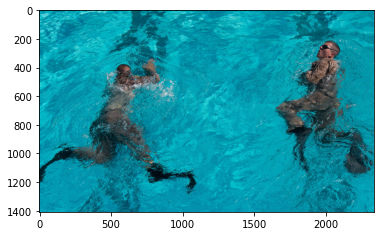

In [3]:
plt.imshow(img)
plt.show()

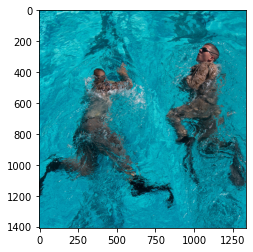

In [4]:
#direct carving one seam at a time

new_img = img.copy()
cols_removed = 1000

for _ in tqdm(range(cols_removed)):
    carver = fastCarver(new_img)
    mask = carver.seam_mask()
    r,c = mask.shape
    new_img=new_img[np.stack([mask]*3,axis=2)].reshape([r,c-1,3])
    
plt.imshow(new_img)
plt.show()

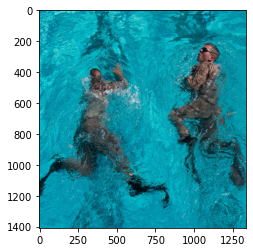

In [5]:
#slightly faster by reusing the same energy (results might be slightly worse)

new_img = img.copy()
cols_removed = 1000
carver = fastCarver(new_img)
E_raw = carver.calc_energy()

E=E_raw.copy()

for _ in tqdm(range(cols_removed)): 
    mask = carver.seam_mask(E.copy())
    r,c = mask.shape
    E=E[mask].reshape((r,c-1))
    new_img=new_img[np.stack([mask]*3,axis=2)].reshape([r,c-1,3])

plt.imshow(new_img)
plt.show()

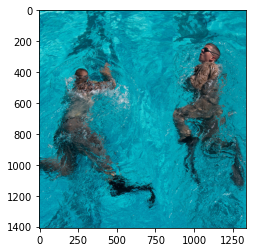

In [6]:
#Compute region of interest before finding seam

new_img = img.copy()
r,c,_ =  new_img.shape

downsample = c//10

cols_removed = 1000
carver = fastCarver(new_img)

E=carver.calc_energy()
lb,rb = 0, new_img.shape[1]

low_res_img = transform.resize(new_img, (r//downsample,c//downsample,3))
lr_carver = fastCarver(low_res_img)
E_lr = lr_carver.calc_energy()

for i in tqdm(range(cols_removed)): 
    r,c,_ = new_img.shape
    
    if i%downsample==0:   
   
        lr_mask = lr_carver.seam_mask(E_lr.copy())
        rlr,rlc = E_lr.shape
        E_lr=E_lr[lr_mask].reshape((rlr,rlc-1))
        roi_boundaries = np.argwhere(~lr_mask.all(axis=0)).flatten()
        lb, rb = max(0,(roi_boundaries[0]-1)*downsample,0),\
                 min((roi_boundaries[-1]+1)*downsample,c)
    
    
    mask = carver.seam_mask(E[:,lb:rb].copy())
    mask = np.concatenate([np.ones((r,lb),dtype=bool),
                           mask,
                           np.ones((r,c-rb),dtype=bool)],axis=1)
    rb-=1
    E=E[mask].reshape((r,c-1))
    new_img=new_img[np.stack([mask]*3,axis=2)].reshape([r,c-1,3])

plt.imshow(new_img)
plt.show()


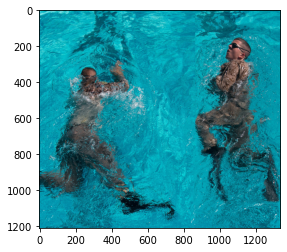

In [8]:
#adaptive ROI/energy strategy (same as cell above but for small ncol counts uses energy trick only)
fullcarver = roiSeamCarver(img)
plt.imshow(fullcarver.carve(nrows=200,ncols=1000))
plt.show()

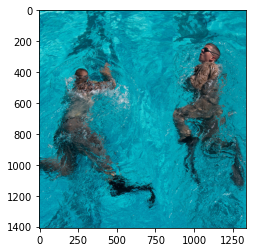

In [17]:
fullcarver = roiSeamCarver(img)
plt.imshow(fullcarver.carve(nrows=0,ncols=1000))
plt.show()

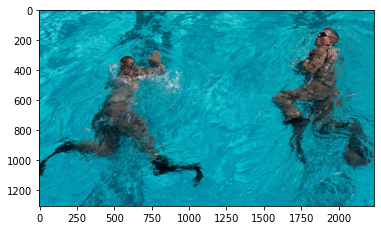

In [10]:
#adaptive ROI/energy strategy
plt.imshow(fullcarver.carve(100,100))
plt.show()

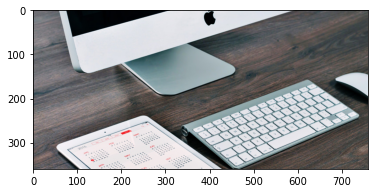

In [12]:
#different image
img2 = io.imread('../test_seamcarving/img/unsplash.jpg')
plt.imshow(img2)

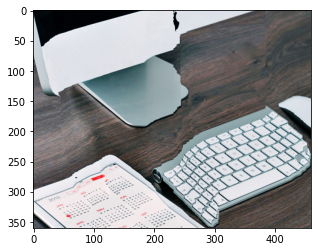

In [13]:
#region of interest seam carve

new_img = img2.copy()
r,c,_ =  new_img.shape

downsample = c//10


cols_removed = 300
carver = fastCarver(new_img)

E=carver.calc_energy()
lb,rb = 0, new_img.shape[1]

low_res_img = transform.resize(new_img, (r//downsample,c//downsample,3))
lr_carver = fastCarver(low_res_img)
E_lr = lr_carver.calc_energy()

for i in tqdm(range(cols_removed)): 
    r,c,_ = new_img.shape
    
    if i%downsample==0:   
   
        lr_mask = lr_carver.seam_mask(E_lr.copy())
        rlr,rlc = E_lr.shape
        E_lr=E_lr[lr_mask].reshape((rlr,rlc-1))
        roi_boundaries = np.argwhere(~lr_mask.all(axis=0)).flatten()
        lb, rb = max(0,(roi_boundaries[0]-1)*downsample,0),\
                 min((roi_boundaries[-1]+1)*downsample,c)
    
    
    mask = carver.seam_mask(E[:,lb:rb].copy())
    mask = np.concatenate([np.ones((r,lb),dtype=bool),
                           mask,
                           np.ones((r,c-rb),dtype=bool)],axis=1)
    rb-=1
    E=E[mask].reshape((r,c-1))
    new_img=new_img[np.stack([mask]*3,axis=2)].reshape([r,c-1,3])

plt.imshow(new_img)
plt.show()


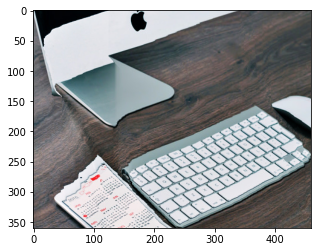

In [14]:
#slightly faster but with issues by using the same energy

new_img = img2.copy()
cols_removed = 300
carver = fastCarver(new_img)
E_raw = carver.calc_energy()

E=E_raw.copy()

for _ in tqdm(range(cols_removed)): 
    mask = carver.seam_mask(E.copy())
    r,c = mask.shape
    E=E[mask].reshape((r,c-1))
    new_img=new_img[np.stack([mask]*3,axis=2)].reshape([r,c-1,3])

plt.imshow(new_img)
plt.show()

In [15]:
fullcarver2 = roiSeamCarver(img2)

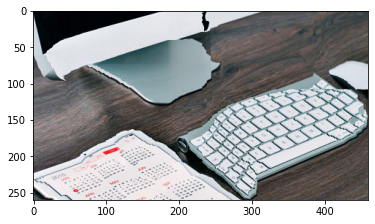

In [16]:
plt.imshow(fullcarver2.carve(100,300))
plt.show()